In [3]:
from graph_tool.all import *

In [4]:
g = Graph()

In [7]:
ug = Graph(directed=False)

In [9]:
v1 = g.add_vertex()
v2 = g.add_vertex()
e = g.add_edge(v1, v2)


In [14]:
g = Graph([('foo', 'bar', .5), ('gnu', 'gnat', .78)], hashed=True,

          eprops=[('weight', 'double')])

In [12]:
graph_draw(g, vertex_text=g.vertex_index, output="two-nodes.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x71c2f25f64e0, at 0x71c3c4c83380>

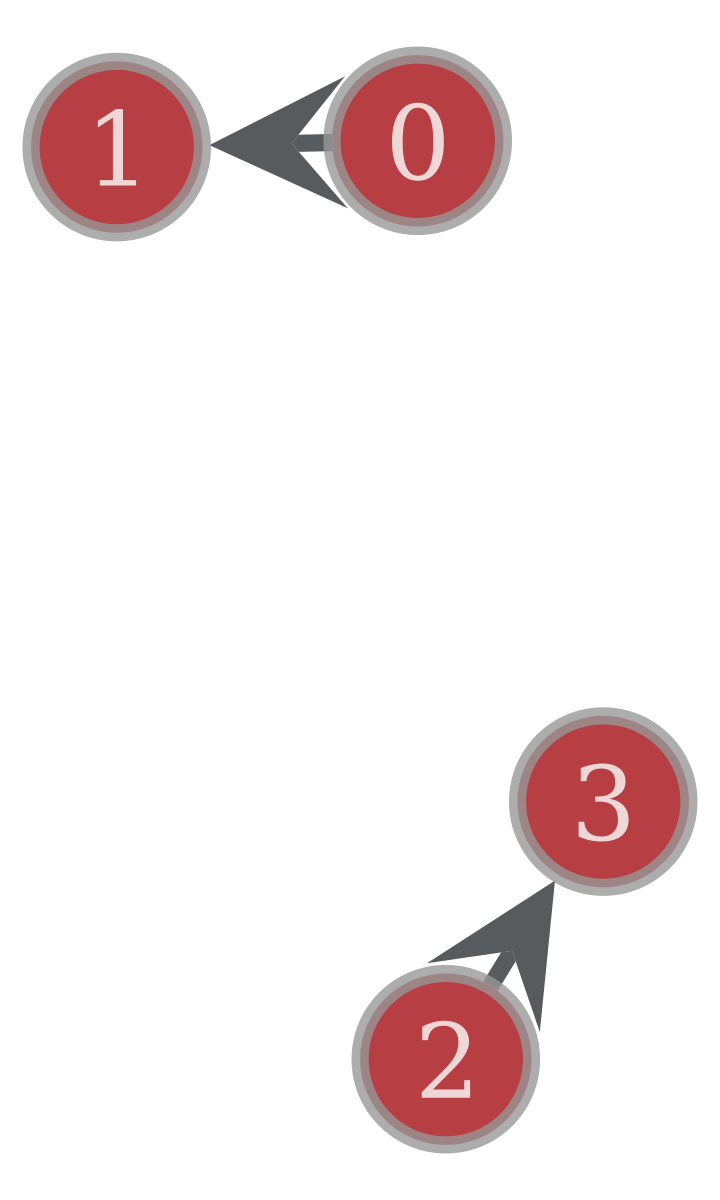

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x71c2f256a540, at 0x71c2f25f4d40>

In [15]:
graph_draw(g, vertex_text=g.vertex_index)

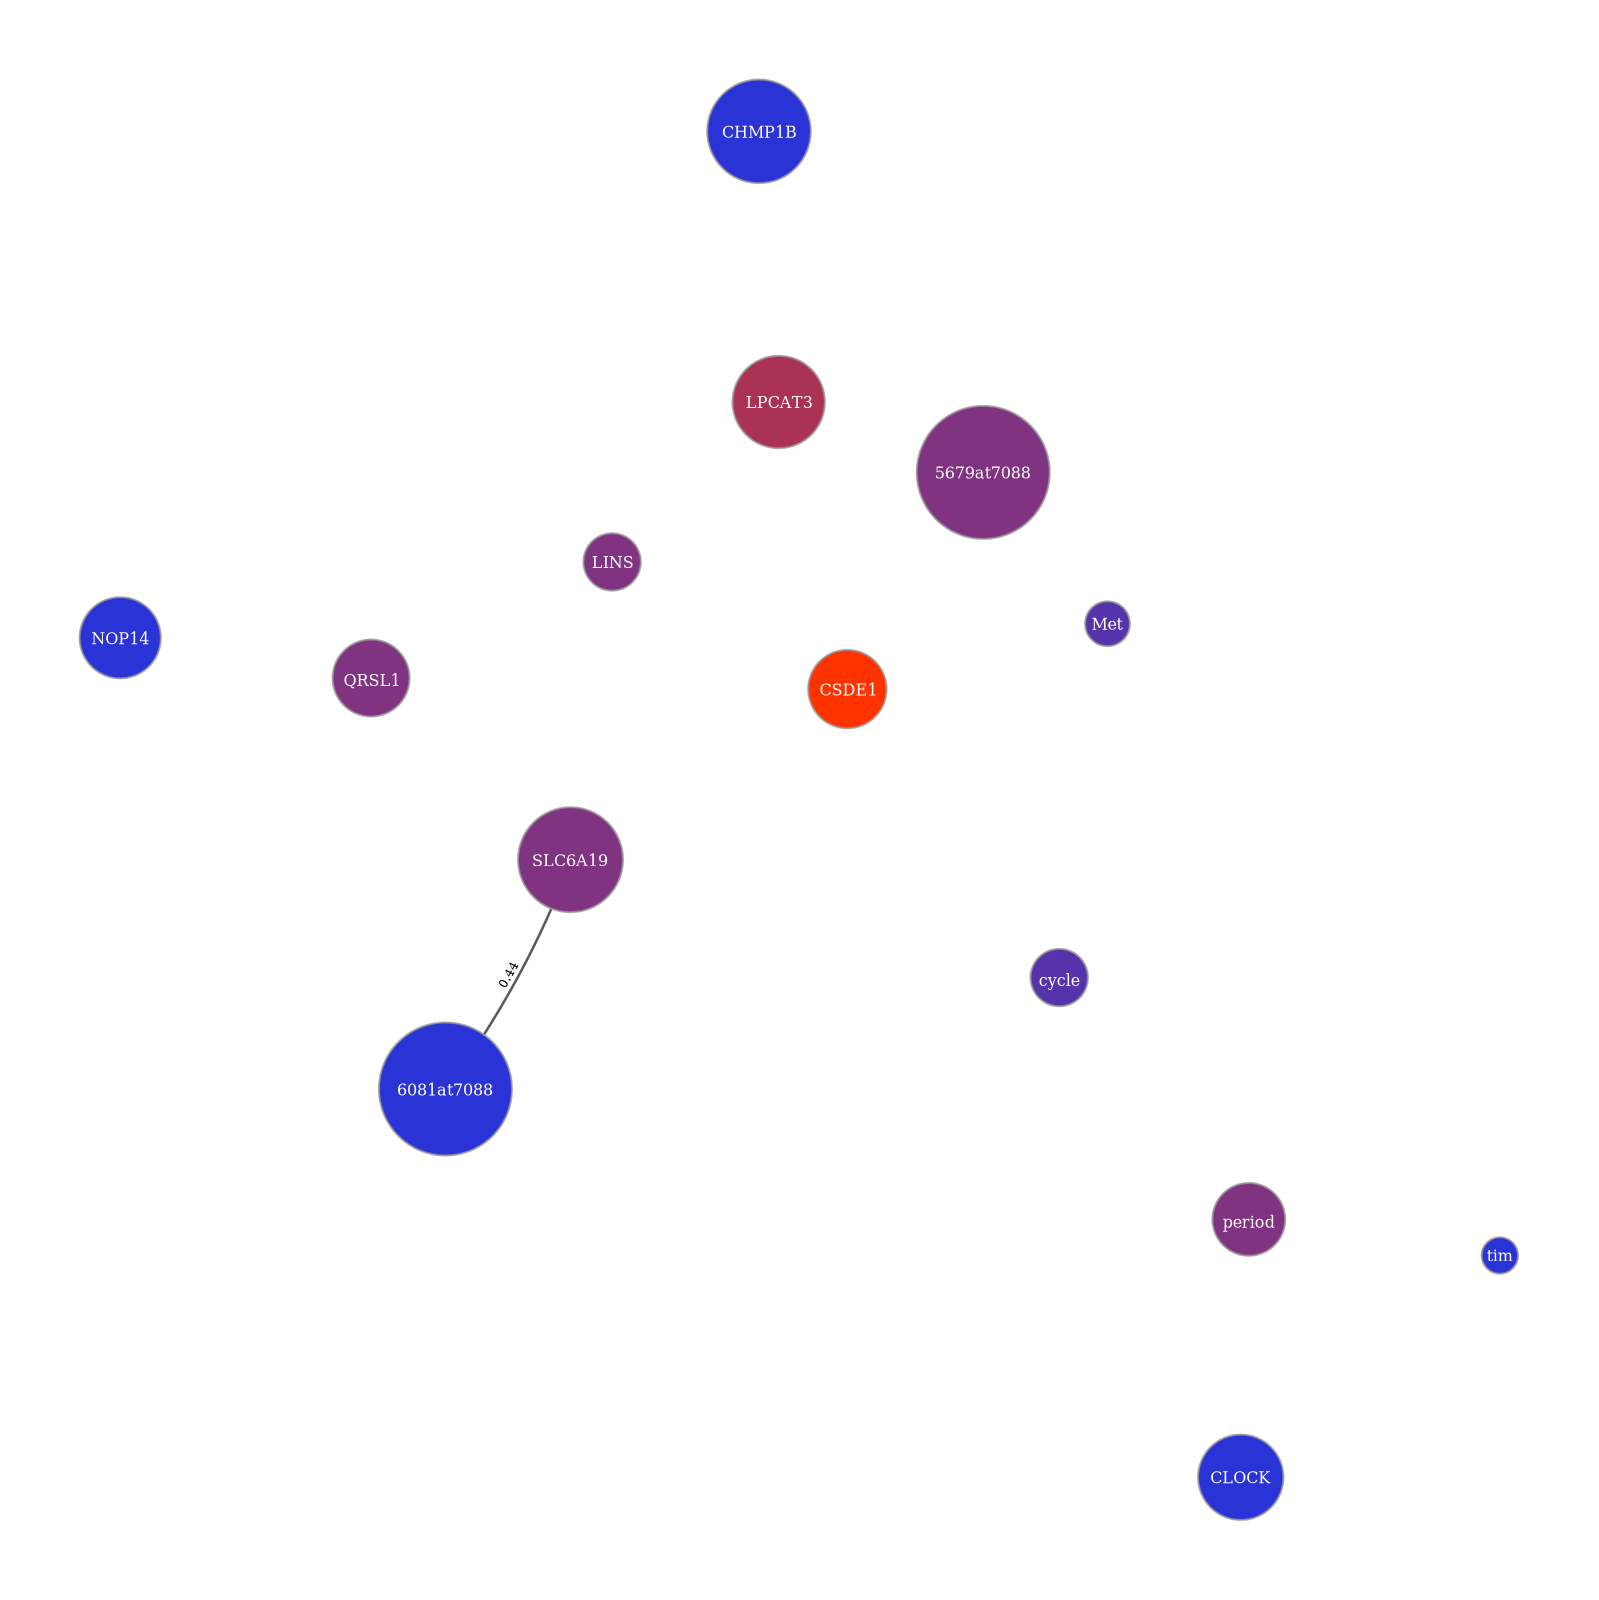

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x71c2ea2a0f20, at 0x71c2d1420980>

In [106]:
import pandas as pd
from graph_tool.all import *

# Load data

location = "/mnt/c/Users/sauba/Desktop/20.RERConverge_trimmed/3.New_colias/61.New_alignment_colias"

df = pd.read_csv(f"{location}/10.ERC_networks_rho_cluster/filtered_dataset_core_set.csv")

# df['edge_key'] = df.apply(lambda row: tuple(sorted([row['Annotation_gene1'], row['Annotation_gene2']])), axis=1)
# df = df.drop_duplicates('edge_key')

# Filter edges with 0.4 < correlation < 1
# df = df[(df['Correlation'] > 0.4) & (df['Correlation'] < 1.0)]

# Initialize graph
g = Graph(directed=False)

# Property map for node names (annotation)
name_prop = g.new_vertex_property("string")

# Map gene annotations to vertices
node_map = {}
def get_vertex(name):
    if name not in node_map:
        v = g.add_vertex()
        node_map[name] = v
        name_prop[v] = name
    return node_map[name]

# Add edges
weight = g.new_edge_property("float")
for _, row in df.iterrows():
    v1 = get_vertex(row["Annotation_gene1"])
    v2 = get_vertex(row["Annotation_gene2"])
    if row["Correlation"] > 0.4 and row["Correlation"] < 1.0:
        e = g.add_edge(v1, v2)
        weight[e] = row["Correlation"]



# Set fixed node size (e.g., all nodes size 10)
vsize = g.new_vertex_property("float")
vsize.a = 10

weight = g.new_edge_property("float")       # numeric correlation
pen_width = g.new_edge_property("float")    # thickness
edge_label = g.new_edge_property("string")  # label to show

# Optional: thickness scaling
min_w, max_w = 1.0, 5.0
min_corr = 0.4
max_corr = 0.99

# Track edges to avoid duplicates
added_edges = set()

for _, row in df.iterrows():
    source = row['Annotation_gene1']
    target = row['Annotation_gene2']
    key = tuple(sorted([source, target]))
    if key in added_edges:
        continue
    added_edges.add(key)

    v1 = get_vertex(source)
    v2 = get_vertex(target)
    # if (row["Correlation"] > 0.4 and row["Correlation"] < 1.0):
    #     e = g.add_edge(v1, v2)
    
    #     corr = row['Correlation']
    #     weight[e] = corr

    # Scale pen width
    scaled = min_w + (corr - min_corr) / (max_corr - min_corr) * (max_w - min_w)
    pen_width[e] = scaled

    # Set text label (e.g., 0.47)
    edge_label[e] = f"{corr:.2f}"

# Add degree-based color
deg = g.degree_property_map("total")
max_deg = max(deg.a) if max(deg.a) > 0 else 1
color = g.new_vertex_property("vector<float>")
for v in g.vertices():
    d = deg[v]
    color[v] = [d / max_deg, 0.2, 1.0 - d / max_deg, 1.0]  # RGBA

# name_prop[v] = row["Annotation_gene1"][:3]

# Draw graph
graph_draw(g,
           vertex_text=name_prop,
           vertex_fill_color=color,
           vertex_font_size=8,
           vertex_size=vsize,
           edge_pen_width=pen_width,
           edge_text=edge_label,  # 🔍 This shows correlation values
           # output_size=(3200, 3200),
           output_size=(800, 800))
           # output="graph_with_edge_labels_core_non_diapause.pdf")

In [52]:
color

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x71c2f25f80e0, at 0x71c2e1ffa870>

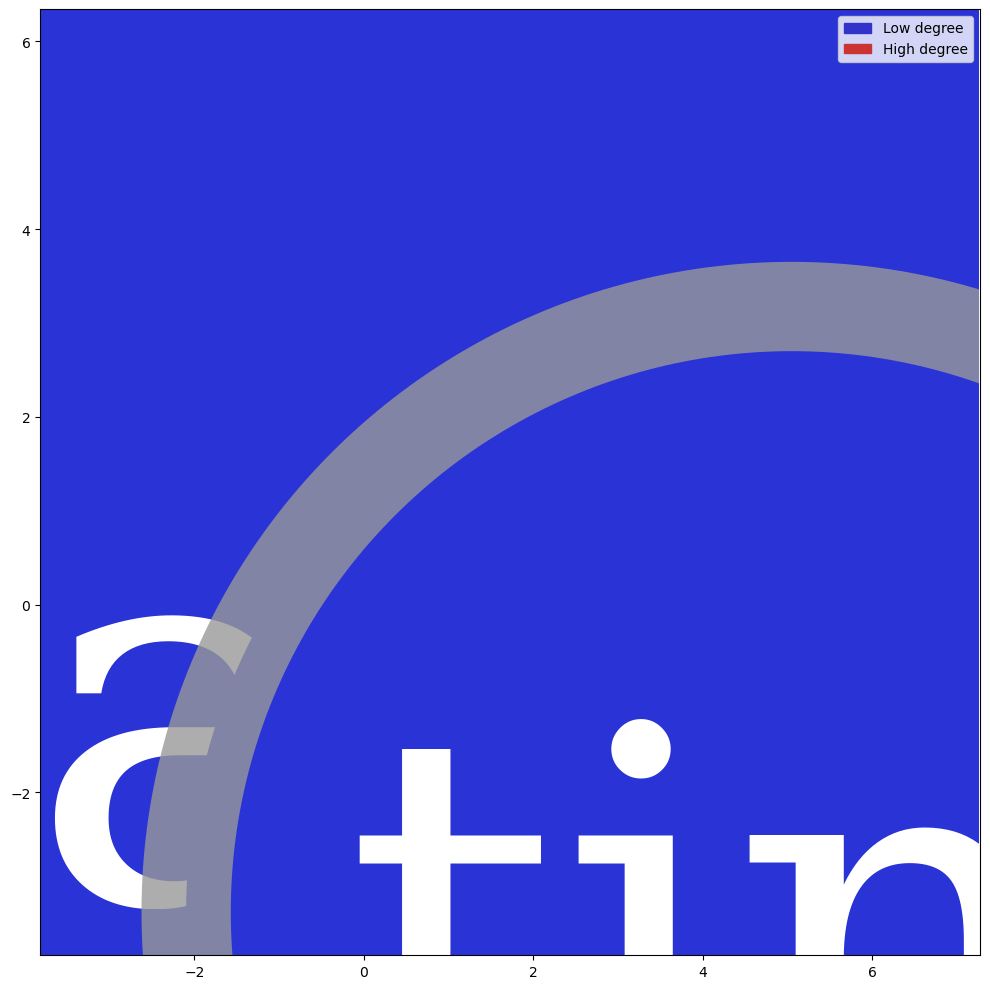

In [28]:
deg = g.degree_property_map("total")
max_deg = max(deg.a) if max(deg.a) > 0 else 1

# Color: RGBA based on degree
color = g.new_vertex_property("vector<float>")
for v in g.vertices():
    d = deg[v]
    color[v] = [d / max_deg, 0.2, 1.0 - d / max_deg, 1.0]

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a matplotlib figure (no need for ax)
fig = plt.figure(figsize=(10, 10))

# Draw the graph (link to matplotlib figure)
graph_draw(g,
           vertex_text=name_prop,
           vertex_fill_color=color,
           vertex_size=vsize,
           edge_pen_width=2,
           mplfig=fig)  # NOT (fig, ax)

# Create legend manually
legend_elements = [
    mpatches.Patch(color=[0.2, 0.2, 0.8, 1.0], label='Low degree'),
    mpatches.Patch(color=[0.8, 0.2, 0.2, 1.0], label='High degree')
]

# Add the legend to the figure
plt.legend(handles=legend_elements, loc='upper right')

# Save or show
plt.tight_layout()
plt.savefig("graph_with_legend.png", dpi=300)
plt.show()

In [27]:
from graph_tool.all import *

# Load data

location = "/mnt/c/Users/sauba/Desktop/20.RERConverge_trimmed/3.New_colias/61.New_alignment_colias"

df = pd.read_csv(f"{location}/10.ERC_networks_rho_cluster/filtered_dataset_full_set_non_diapause.csv")

df['edge_key'] = df.apply(lambda row: tuple(sorted([row['Annotation_gene1'], row['Annotation_gene2']])), axis=1)
df = df.drop_duplicates('edge_key')

# Filter edges with 0.4 < correlation < 1
df = df[(df['Correlation'] > 0.4) & (df['Correlation'] < 1.0)]

# Initialize graph
g = Graph(directed=False)

# Property map for node names (annotation)
name_prop = g.new_vertex_property("string")

# Map gene annotations to vertices
node_map = {}
def get_vertex(name):
    if name not in node_map:
        v = g.add_vertex()
        node_map[name] = v
        name_prop[v] = name
    return node_map[name]

# Add edges
weight = g.new_edge_property("float")
for _, row in df.iterrows():
    v1 = get_vertex(row["Annotation_gene1"])
    v2 = get_vertex(row["Annotation_gene2"])
    e = g.add_edge(v1, v2)
    weight[e] = row["Correlation"]

# Add degree-based color
deg = g.degree_property_map("total")
max_deg = max(deg.a) if max(deg.a) > 0 else 1
color = g.new_vertex_property("vector<float>")
for v in g.vertices():
    d = deg[v]
    color[v] = [d / max_deg, 0.2, 1.0 - d / max_deg, 1.0]  # RGBA

# Set fixed node size (e.g., all nodes size 10)
vsize = g.new_vertex_property("float")
vsize.a = 10

weight = g.new_edge_property("float")       # numeric correlation
pen_width = g.new_edge_property("float")    # thickness
edge_label = g.new_edge_property("string")  # label to show

# Optional: thickness scaling
min_w, max_w = 1.0, 5.0
min_corr = df['Correlation'].min()
max_corr = df['Correlation'].max()

# Track edges to avoid duplicates
added_edges = set()

for _, row in df.iterrows():
    source = row['Annotation_gene1']
    target = row['Annotation_gene2']
    key = tuple(sorted([source, target]))
    if key in added_edges:
        continue
    added_edges.add(key)

    v1 = get_vertex(source)
    v2 = get_vertex(target)
    e = g.add_edge(v1, v2)

    corr = row['Correlation']
    weight[e] = corr

    # Scale pen width
    scaled = min_w + (corr - min_corr) / (max_corr - min_corr) * (max_w - min_w)
    pen_width[e] = scaled

    # Set text label (e.g., 0.47)
    edge_label[e] = f"{corr:.2f}"

# name_prop[v] = row["Annotation_gene1"][:3]

# Draw graph
graph_draw(g,
           vertex_text=name_prop,
           vertex_fill_color=color,
           vertex_font_size=8,
           vertex_size=vsize,
           edge_pen_width=pen_width,
           edge_text=edge_label,  # 🔍 This shows correlation values
           output_size`=(3200, 3200),
           output="graph_with_edge_labels_full_non_diapause.png")

In [53]:
from graph_tool.all import *
import pandas as pd

# Load data
location = "/mnt/c/Users/sauba/Desktop/20.RERConverge_trimmed/3.New_colias/61.New_alignment_colias"
df = pd.read_csv(f"{location}/10.ERC_networks_rho_cluster/filtered_dataset_full_set_non_diapause.csv")

# Create unique edge key (undirected)
df['edge_key'] = df.apply(lambda row: tuple(sorted([row['Annotation_gene1'], row['Annotation_gene2']])), axis=1)
df = df.drop_duplicates('edge_key')

# Filter edges by correlation threshold
df = df[(df['Correlation'] > 0.4) & (df['Correlation'] < 1.0)]

# Initialize graph
g = Graph(directed=False)

# Property maps
name_prop = g.new_vertex_property("string")
vsize = g.new_vertex_property("float")
color = g.new_vertex_property("vector<float>")
pen_width = g.new_edge_property("float")
edge_label = g.new_edge_property("string")
weight = g.new_edge_property("float")

# Map for vertex lookup
node_map = {}

def get_vertex(name):
    if name not in node_map:
        v = g.add_vertex()
        node_map[name] = v
        name_prop[v] = name
    return node_map[name]

# Add all unique nodes (including isolated ones)
all_genes = set(df['Annotation_gene1']).union(set(df['Annotation_gene2']))
for gene in all_genes:
    get_vertex(gene)

# Edge drawing: thickness and labels based on correlation
min_w, max_w = 1.0, 5.0
min_corr = df['Correlation'].min()
max_corr = df['Correlation'].max()

added_edges = set()
for _, row in df.iterrows():
    source = row['Annotation_gene1']
    target = row['Annotation_gene2']
    key = tuple(sorted([source, target]))
    if key in added_edges:
        continue
    added_edges.add(key)

    v1 = get_vertex(source)
    v2 = get_vertex(target)
    e = g.add_edge(v1, v2)

    corr = row['Correlation']
    weight[e] = corr

    # Scale edge thickness
    scaled = min_w + (corr - min_corr) / (max_corr - min_corr) * (max_w - min_w)
    pen_width[e] = scaled

    # Set label
    edge_label[e] = f"{corr:.2f}"

# Node degree-based color
deg = g.degree_property_map("total")
max_deg = max(deg.a) if max(deg.a) > 0 else 1
for v in g.vertices():
    d = deg[v]
    color[v] = [d / max_deg, 0.2, 1.0 - d / max_deg, 1.0]  # RGBA

# Fixed node size
vsize.a = 10

# Draw graph
graph_draw(g,
           vertex_text=name_prop,
           vertex_fill_color=color,
           vertex_font_size=8,
           vertex_size=vsize,
           edge_pen_width=pen_width,
           edge_text=edge_label,
           output_size=(3200, 3200),
           output="graph_with_edge_labels_full_non_diapause.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x71c2ebaf3f80, at 0x71c2e1fb04d0>

In [86]:
import pandas as pd
from graph_tool.all import *

# Load data

location = "/mnt/c/Users/sauba/Desktop/20.RERConverge_trimmed/3.New_colias/61.New_alignment_colias"

df = pd.read_csv(f"{location}/10.ERC_networks_rho_cluster/filtered_dataset_full_set_diapause.csv.csv")
print(df)
# df['edge_key'] = df.apply(lambda row: tuple(sorted([row['Annotation_gene1'], row['Annotation_gene2']])), axis=1)
# df = df.drop_duplicates('edge_key')

# Filter edges with 0.4 < correlation < 1
# df = df[(df['Correlation'] > 0.4) & (df['Correlation'] < 1.0)]

# Initialize graph
g = Graph(directed=False)

# Property map for node names (annotation)
name_prop = g.new_vertex_property("string")

# Map gene annotations to vertices
node_map = {}
def get_vertex(name):
    if name not in node_map:
        v = g.add_vertex()
        node_map[name] = v
        name_prop[v] = name
    return node_map[name]
# print(node_map)
# Add edges
# weight = g.new_edge_property("float")
# for _, row in df.iterrows():
#     v1 = get_vertex(row["Annotation_gene1"])
#     v2 = get_vertex(row["Annotation_gene2"])
#     if row["Correlation"] > 0.4 and row["Correlation"] < 1.0:
#         e = g.add_edge(v1, v2)
#         weight[e] = row["Correlation"]
# # print(node_map)



# # Set fixed node size (e.g., all nodes size 10)
vsize = g.new_vertex_property("float")
vsize.a = 10

# weight = g.new_edge_property("float")       # numeric correlation
pen_width = g.new_edge_property("float")    # thickness
edge_label = g.new_edge_property("string")  # label to show

# Optional: thickness scaling
min_w, max_w = 1.0, 5.0
min_corr = 0.4
max_corr = 0.99

# # Track edges to avoid duplicates
added_edges = set()

# for _, row in df.iterrows():
#     source = row['Annotation_gene1']
#     target = row['Annotation_gene2']
#     key = tuple(sorted([source, target]))
#     if key in added_edges:
#         continue
#     added_edges.add(key)

#     v1 = get_vertex(source)
#     v2 = get_vertex(target)
#     if (row["Correlation"] > 0.4 and row["Correlation"] < 1.0):
#         e = g.add_edge(v1, v2)
    
# #     #     corr = row['Correlation']
# #     #     weight[e] = corr

# #     # Scale pen width
# #     scaled = min_w + (corr - min_corr) / (max_corr - min_corr) * (max_w - min_w)
# #     pen_width[e] = scaled

# #     # Set text label (e.g., 0.47)
# #     edge_label[e] = f"{corr:.2f}"

# # # Add degree-based color
# # deg = g.degree_property_map("total")
# # max_deg = max(deg.a) if max(deg.a) > 0 else 1
# # color = g.new_vertex_property("vector<float>")
# # for v in g.vertices():
# #     d = deg[v]
# #     color[v] = [d / max_deg, 0.2, 1.0 - d / max_deg, 1.0]  # RGBA

# # # name_prop[v] = row["Annotation_gene1"][:3]

# # # Draw graph
# # graph_draw(g,
# #            vertex_text=name_prop,
# #            vertex_fill_color=color,
# #            vertex_font_size=8,
# #            vertex_size=vsize,
# #            edge_pen_width=pen_width,
# #            edge_text=edge_label,  # 🔍 This shows correlation values
# #            # output_size=(3200, 3200),
# #            output_size=(800, 800))
#            # output="graph_with_edge_labels_core_non_diapause.pdf")

          Gene1       Gene2  Correlation Annotation_gene1 Annotation_gene2
0    5423at7088  3362at7088     0.475749            QRSL1            NOP14
1    5423at7088  2036at7088     0.492656            QRSL1             LINS
2    5423at7088  3811at7088     0.290731            QRSL1           LPCAT3
3    5423at7088       cycle     0.052486            QRSL1            cycle
4    5423at7088  5474at7088     0.190893            QRSL1            CLOCK
..          ...         ...          ...              ...              ...
86  12510at7088  5679at7088     0.162370           CHMP1B       5679at7088
87  12510at7088  1846at7088     0.277586           CHMP1B          SLC6A19
88   1422at7088  5679at7088     0.034006              tim       5679at7088
89   1422at7088  1846at7088    -0.024156              tim          SLC6A19
90   5679at7088  1846at7088     0.297118       5679at7088          SLC6A19

[91 rows x 5 columns]
{'QRSL1': <Vertex object with index '0' at 0x71c2e0e47d40>, 'NOP14': <Vertex 

In [87]:
g = Graph()

v1 = g.add_vertex()

v2 = g.add_vertex()

e = g.add_edge(v1, v2)

print(v1.out_degree())

1


In [243]:
import pandas as pd
from graph_tool.all import *
from collections import defaultdict
import numpy as np

# Load data

location = "/mnt/c/Users/sauba/Desktop/20.RERConverge_trimmed/3.New_colias/61.New_alignment_colias"

df = pd.read_csv(f"{location}/10.ERC_networks_rho_cluster/Filtered_set_cluster_rho_set_full.csv")
df = df[(df['Correlation'] > 0.4) & (df['Correlation'] < 1.0)]
# df = df[df['Correlation'] < 1.0]

g = Graph(directed=False)

name_prop = g.new_vertex_property("string")
weight = g.new_edge_property("float")
pen_width = g.new_edge_property("float")
edge_label = g.new_edge_property("string")

vsize = g.new_vertex_property("float")
vsize.a = 1

min_w, max_w = 1.0, 5.0
min_corr = 0.4
max_corr = 0.99


node_map = {}
def get_vertex(name):
    if name not in node_map:
        v = g.add_vertex()
        node_map[name] = v
        name_prop[v] = name
    return node_map[name]

added_edges = set()

for _, row in df.iterrows():
    
    source = row['Annotation_gene1']
    target = row['Annotation_gene2']
    try:
        key = tuple(sorted([source, target]))
    except:
        print(source,target, row)
        assert False

    if key in added_edges:
        continue
    added_edges.add(key)
    v1 = get_vertex(source)
    v2 = get_vertex(target)
    
    if row["Correlation"] > 0.4 and row["Correlation"] < 1.0:
        corr = row["Correlation"]
        e = g.add_edge(v1, v2)
        weight[e] = corr
        scaled = min_w + (corr - min_corr) / (max_corr - min_corr) * (max_w - min_w)
        pen_width[e] = scaled
        # edge_label[e] = f"{corr:.2f}"


# deg = g.degree_property_map("total")
# max_deg = max(deg.a) if max(deg.a) > 0 else 1
# color = g.new_vertex_property("vector<float>")
# for v in g.vertices():
#     d = deg[v]
#     color[v] = [d / max_deg, 0.2, 1.0 - d / max_deg, 1.0]  # RGBA
#     # color[v] = [x * 0.1 for x in range(0, 10)]

deg = g.degree_property_map("total")
max_deg = max(deg.a) if max(deg.a) > 0 else 1
color = g.new_vertex_property("vector<float>")



# Choose a colormap, for example 'viridis', 'plasma', 'magma', 'cividis', 'inferno'
# You can explore other colormaps in matplotlib's documentation.
cmap = plt.colormaps['Spectral_r']
list_of_degree = []
for v in g.vertices():
    d = deg[v]
    list_of_degree.append(d)
    # Normalize degree to be between 0 and 1 for colormap mapping
    log_deg = np.log1p(d) # log1p(x) is log(1+x)
    max_log_deg = np.log1p(max_deg)
    normalized_degree = log_deg / max_log_deg if max_log_deg > 0 else 0
    # normalized_degree = d / max_deg if max_deg > 0 else 0
    
    # Get RGBA color from the colormap
    rgba_color = cmap(normalized_degree)
    color[v] = rgba_color # Assign the RGBA tuple directly

assert False


# --- COMMUNITY DETECTION ---
from graph_tool.inference import minimize_blockmodel_dl
import matplotlib.cm as cm
import numpy as np

# Detect communities (blocks)
state = minimize_blockmodel_dl(g)
blocks = state.get_blocks()

# Color nodes by block
block_ids = blocks.a
num_blocks = len(set(block_ids))


block_dict = defaultdict(list)

for v in g.vertices():

    block_id = blocks[v]
    gene_name = name_prop[v]
    block_dict[block_id].append(gene_name)

# --- CLUSTER-AWARE LAYOUT ---
# This will pull clusters apart based on community membership
pos = sfdp_layout(g, groups=blocks)

# Draw graph with community-based colors
file_name = "rho_set_non_dia"
graph_draw(g,
           pos=pos,  # <-- use the new layout
           vertex_text=name_prop,
           vertex_fill_color=color,
           vertex_font_size=10,
           vertex_size=vsize,
           edge_pen_width=pen_width,
           edge_text=edge_label,
           edge_font_size=8,
           # output_size=(800, 800),
           output_size=(2000, 2000),
           output=f"{location}/10.ERC_networks_rho_cluster/{file_name}.png") 
output = "Block,Gene"
for key, value in block_dict.items():
    for gene_name in value:
        output += f"\n{key},{gene_name}"

with open(f"{location}/10.ERC_networks_rho_cluster/{file_name}.csv", 'w') as out_file:
    out_file.write(output)


AssertionError: 

In [244]:
file_name = "rho_set_full"
# print(list_of_degree)
plt.hist(list_of_degree, bins=max(list_of_degree), edgecolor='black')

# Add labels
plt.title('Histogram')
plt.xlabel('Degree')
plt.ylabel('Count')

# Show plot
plt.savefig(f"{location}/10.ERC_networks_rho_cluster/{file_name}_histogram_output.pdf", format='pdf', bbox_inches='tight')
plt.close()

In [153]:
block_dict = dict(block_dict)
print(block_dict)


{388: ['MBTD1', 'DLGAP5', 'SLC39A6', 'CHAF1B', 'SF3B4', 'Mlc2', 'WFS1', 'RRN3', 'BICC1', 'EVI5L', 'KIAA0430', '7392', 'ACRC', 'USP3', '543', 'COPB2', 'CLOCK', 'Ces3', 'NCAPH', '12696', 'CCT6A', 'MARCH5', 'MEF2C', 'KCTD15', 'RPS3', 'DAP', 'IGF2BP3', 'PLK1', 'SF3B3', 'dsf', '5851', 'RpL3', '10698', 'MAFG', 'DAXX', 'DENND5B', 'EIF2A', 'SMU1', 'SKIV2L', 'GEMIN5'], 207: ['10163', 'SNX16', 'AHSA1', 'ZNHIT1', 'ARCN1', 'TRAF6', 'POLR2G', 'SPR', 'DDIT4L', 'HGD', 'PRCP', 'ACTR8', 'NFYC', 'MRPS25', '4746', 'APIP', 'PRMT8', 'SDHB', '1857', 'BOLL', 'WDR34', 'TXNDC5', 'cycle', 'PAH', 'DYNLRB2', 'ARV1', 'IST1', '11072', '2999', '13053', 'nAChRa8', 'DNAI1', '6081', 'GPSM2', 'SLC6A19', 'RCL1', 'GINS2', 'HGH1', 'VPS4A', 'HLF', 'COPS5', 'SIRT2', 'MAP2K1', '11115', 'HINT3', 'DHPS', 'URM1', 'ASNA1', '14909', 'NUDT3', 'PLCG2', 'NPAS3', 'QRSL1', 'TAF9B', '14251', '9682', '11368', 'BOD1L1', 'ZDHHC7', '10387', 'CA2', 'Orco', 'MED27', 'SUGCT'], 154: ['COPZ1', 'ARFIP1', 'PLS3', 'GPR89A', 'AP1B1', 'SMARCC1', 'SEC

In [164]:
color[v]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [167]:
color[v]

array([0.01204819, 0.2       , 0.98795181, 1.        ])

Plot saved successfully to /mnt/c/Users/sauba/Desktop/20.RERConverge_trimmed/3.New_colias/61.New_alignment_colias/10.ERC_networks_rho_cluster/spectral_r_colormap.pdf


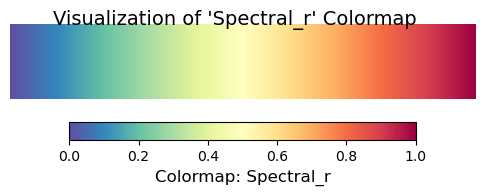

In [179]:
import matplotlib.pyplot as plt
import numpy as np

def plot_colormap(colormap_name, filename=None):
    """
    Plots and displays a specified Matplotlib colormap, with an option to save as PDF.

    Args:
        colormap_name (str): The name of the colormap to plot (e.g., 'Spectral_r').
        filename (str, optional): The name of the file to save the plot.
                                  If None, the plot is only displayed.
                                  Should end with '.pdf' for PDF output.
    """
    try:
        # Get the colormap using the recommended Matplotlib API
        cmap = plt.colormaps[colormap_name]
    except KeyError:
        print(f"Error: Colormap '{colormap_name}' not found.")
        print("Please check the colormap name and ensure it's a valid Matplotlib colormap.")
        return

    # Create a figure and an axes
    fig, ax = plt.subplots(figsize=(6, 1.5))

    # Create a dummy image to attach the colorbar to
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    im = ax.imshow(gradient, aspect='auto', cmap=cmap) # Store the image object

    # Remove axis ticks and labels as they are not needed for a colormap display
    ax.set_axis_off()

    # Add a colorbar to the plot
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal',
                        pad=0.2, shrink=0.8)
    cbar.set_label(f'Colormap: {colormap_name}', fontsize=12)

    plt.suptitle(f"Visualization of '{colormap_name}' Colormap", fontsize=14)

    # Save the figure if a filename is provided
    if filename:
        try:
            plt.savefig(filename, bbox_inches='tight', dpi=300) # dpi for good resolution
            print(f"Plot saved successfully to {filename}")
        except Exception as e:
            print(f"Error saving plot to {filename}: {e}")

    plt.show()

# Call the function to plot the 'Spectral_r' colormap and save it as PDF
# Replace 'spectral_r_colormap.pdf' with your desired filename and path

# Call the function to plot the 'Spectral_r' colormap
plot_colormap ('Spectral_r', filename=f"{location}/10.ERC_networks_rho_cluster/spectral_r_colormap.pdf")